In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.style.use('dark_background')
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

**Read Housing Data**

In [ ]:
data=pd.read_csv("/kaggle/input/boston-housing-dataset/HousingData.csv")
display(data.head())
display(data.columns)

# What do these columns mean?


Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository):

**CRIM**: per capita crime rate by town

**ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.

**INDUS**: proportion of non-retail business acres per town

**CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

**NOX**: nitric oxides concentration (parts per 10 million)

**RM**: average number of rooms per dwelling

**AGE**: proportion of owner-occupied units built prior to 1940

**DIS**: weighted distances to ﬁve Boston employment centers

**RAD**: index of accessibility to radial highways

**TAX**: full-value property-tax rate per $10,000.

**PTRATIO**: pupil-teacher ratio by town 12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 

**LSTAT**: Lower status of the population.

**MEDV**: Median value of owner-occupied homes in $1000s

**The Boston housing dataset contains 506 observations and 14 variables.**

# **Data Preprocessing:**
Let's explore the data to see if we need to make any changes before we use it our super powerful XGBoost model.

In [ ]:
display(data.describe())
display(data.info())

As you noticed, there are null values present in many columns, namely **CRIM, ZN, INDUS, CHAS, AGE, and LSTAT.**
So we will have to fill these null values with some new values, in our case we will use the mean value of each column as a replacement.

In [ ]:
#Fill null values with average of each column
data["CRIM"].fillna(data["CRIM"].mean(),inplace=True)
data["ZN"].fillna(data["ZN"].mean(),inplace=True)
data["INDUS"].fillna(data["INDUS"].mean(),inplace=True)
data["CHAS"].fillna(data["CHAS"].mean(),inplace=True)
data["AGE"].fillna(data["AGE"].mean(),inplace=True)
data["LSTAT"].fillna(data["LSTAT"].mean(),inplace=True)

data.info()

Great, now we have no null values in our dataset. We can go ahead with the further processing.

# **EDA**

We will first visualize and observe the potential output variable for our model,  **MEDV: (Median Value in $1000)**

In [ ]:
plt.figure(figsize=(22,8))
plt.scatter(data.index,data["MEDV"],color="red",lw=3)
plt.plot(data.index,data["MEDV"])
plt.title("Median value of homes (in $1000)")
plt.grid(True)
plt.show()

As we can see, the values are vastly distributed, there is no real pattern to these values. Most of them lie between the range $(20000-25000) 

The maximum value of houses is $50000 while the minimum is somewhere around 5000.

**Next, we will observe the frequency plot for all the features and notice if we need to improve them.**

In [ ]:
fig, ax1 = plt.subplots(7,2, figsize=(20,25))
k = 0
columns = list(data.columns)
for i in range(7):
    for j in range(2):
            sns.distplot(data[columns[k]], ax = ax1[i][j], color = 'green')
            ax1[i][j].grid(True)
            k += 1
plt.show()

Clearly, most of the features are okay as far as building a model is concerned, only issue is the **DIS** feature which is very much skewed to the left. We will need to do something about that.

All we need to do is take a log transform of the columns and use it as shown below.

In [ ]:
def log_transform(col):
    return np.log(col[0])

data["DIS"]=data[["DIS"]].apply(log_transform, axis=1)
#Plot
sns.distplot(data["DIS"], color = 'green')
plt.grid(True)
plt.show()

Great, this is done too! Now the columns looks much better.

**Next step is very important, we will plot the absolute correlation of each input feature with the output feature (MEDV)**

In [ ]:
plt.figure(figsize=(14,6))
corr=abs(data.corr())
sns.heatmap(corr,annot=True,linewidth=1,cmap="Blues")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(corr["MEDV"].sort_values(ascending=False)[1:],label="Correlation",color="red")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

As we can see, features **LSTAT (0.72), RM(0.7), PTRATIO (0.51), INDUS (0.48), and TAX (0.47)** have the highest correlation with the median value of houses.

We will now plot the regression plots for these features using the seaborn visualization library to observe and understand if these features have a positive or negative correlation with the output variable.

In [ ]:
fig, ax1 = plt.subplots(3,2, figsize=(20,15))
k = 0
columns = ["LSTAT","RM","PTRATIO","INDUS","NOX","AGE"]
for i in range(3):
    for j in range(2):
            sns.regplot(data[columns[k]],data["MEDV"],ax=ax1[i][j],color="green")
            ax1[i][j].grid(True)
            k += 1
plt.show()

So clearly, only **RM** has a positive correlation with MEDV whereas the other features have a negative correlation.

Next is the box plot for each feature to notice if it has outliners, and them getting rid of them.

In [ ]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index],color="yellow")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Almost all the features have many outliners and hence we will need to take care of them. Its simple, we will scale the data before feeding it to our model.

**What is feature scaling ?**

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing to handle highly varying magnitudes or values or units. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.

We will use the standardization technique to perform feature scaling,

**Standardization:** It is a very effective technique which re-scales a feature value so that it has distribution with 0 mean value and variance equals to 1. The tool we will use is StandardScaler from the preprocessing library in Scikitlearn. (Check out the library imported at the top)

**Split and scale the data:**

**X** comprises of all the input features we will use to train the model, while **Y** comprises of the output feature (Median Value of Boston Houses) 

In [ ]:
X=data.iloc[:,0:13]
Y=data.iloc[:,13]

print("Unscaled Data: \n")
display(X)  #Unscaled data
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Scaled Data: \n")
display(X)  #Scaled input data

# **XGBoost Model 🦾🦾**
**XGBoost (eXtreme Gradient Boosting)** is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. When it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now.
Initially started as a research project in 2014, XGBoost has quickly become one of the most popular Machine Learning algorithms of the past few years. 

It is not only an algorithm. It’s an entire open-source library, designed as an optimized implementation of the Gradient Boosting framework. It focuses on speed, flexibility, and model performances. Its strength doesn’t only come from the algorithm, but also from all the underlying system optimization.

**What is Boosting?**

Boosting is just a method that uses the principle of ensemble learning, but in sequential order. It a process that combines decisions from multiple underlying models, and uses a voting technique to determine the final prediction. Boosting is a type of ensemble learning that uses the previous model's result as an input to the next one. Instead of training models separately, boosting trains models sequentially, each new model being trained to correct the errors of the previous ones. At each iteration (round), the outcomes predicted correctly are given a lower weight, and the ones wrongly predicted a higher weight. It then uses a weighted average to produce a final outcome.

**What is Gradient Boosting?**

Finally, Gradient Boosting is a boosting method where errors are minimized using a gradient descent algorithm. Simply put, Gradient descent is an iterative optimization algorithm used to minimize a loss function.
The loss function quantifies how far off our prediction is from the actual result for a given data point. The better the predictions, the lower will be the output of your loss function.

To put into perspective how powerful XGBoost algorithm is, it is an **optimized implementation** of this Gradient Boosting method!

**As demonstrated in the chart below, XGBoost model has the best combination of prediction performance and processing time compared to other algorithms. No wonder XGBoost is widely used in recent Data Science competitions.**

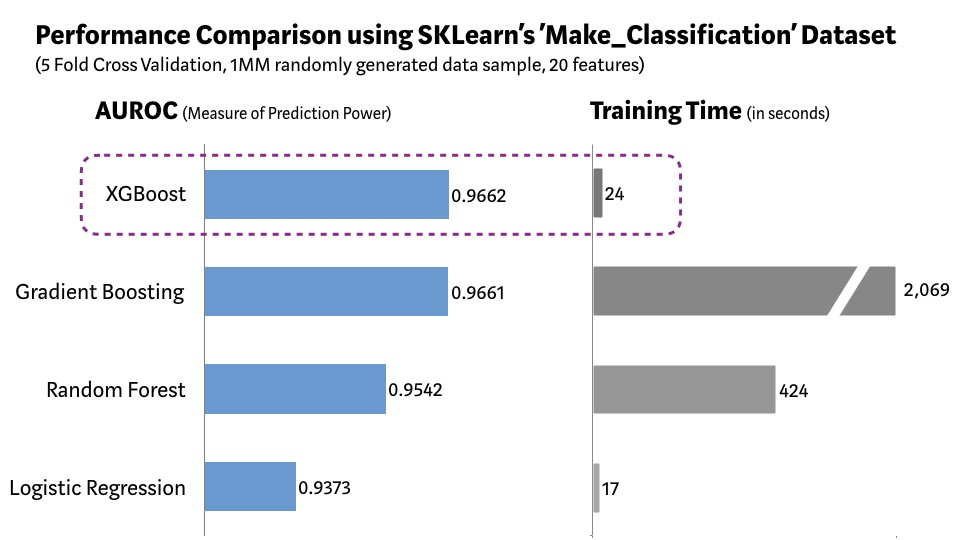

**Now the very main part, as we have prepocessed the data to some extent and also understood a little about XGBoost, we will build our XGBoost model.**

We will split the data into training and testing parts using **train_test_split by scikit-learn** and use it in our model.



In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=94)

First off, we will build a basic XGBoost model without tuning any of it's hyperparameters as shown below.

**Without hyperparameter tuning**

In [ ]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror')  #Our XGBoost model
xgbr.fit(X_train,Y_train)

#Generate predicted values
Y_pred = xgbr.predict(X_test)

#Calculate and print the RMSE and the accuracy of our model.
mse=mean_squared_error(Y_test, Y_pred)
score=r2_score(Y_test,Y_pred)
print("Root Mean Square Error: %.2f" % (mse**(0.5)))
print("Accuracy: {} %".format(round((score*100),2)))

**We got values with a RMSE of 2.77 and accuracy 91.41%**

There's nothing wrong with this model and it's good for a beginner, but we can further improve the accuracy by mere fine-tuning of the hyperparameters.

A hyperparameter is a type of parameter, external to the model, set before the learning process begins. It’s tunable and can directly affect how well a model performs. Note that there are several parameters you can tune when working with XGBoost. 

Our main aim is to reduce RMSE as much as  we can while increasing the accuracy of the model.

**The most common parameters are:**

1. **max_depth**: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit. The value must be an integer greater than 0.

2. **learning_rate**: The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum. The value must be between 0 and 1.

3. **n_estimators**: The number of trees in our ensemble. Equivalent to the number of boosting rounds. The value must be an integer greater than 0.

4. **colsample_bylevel**: Represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting. The value must be between 0 and 1.

5. **subsample**: Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting. The value must be between 0 and 1.

6. **reg_alpha**: L1 regularization on the weights (Lasso Regression). When working with a large number of features, it might improve speed performances. It can be any integer

> **NOTE: The reasonable values to start off would be,**
> 
> max_depth: 3–10 
> 
> n_estimators: 100 (lots of observations) to 1000 (few observations)
> 
> 
> learning_rate: 0.01–0.3
> 
> 
> colsample_bylevel: 0.3–1
> 
> 
> subsample: 0.6–1

Initially, you can focus on optimizing **max_depth** and **n_estimators**.
You can then play along with the **learning_rate**, and increase it to speed up the model without decreasing the performances. If it becomes faster without losing in performances, you can increase the number of **n_estimators** to try to increase the performances.

**With hyperparameter tuning**

In [ ]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                        random_state=50,
                        max_depth=6,
                        learning_rate = 0.08,
                        n_estimators = 500,
                        colsample_bylevel = 0.4,
                        reg_alpha = 1,
                        subsample = 1,
                       )

xgbr.fit(X_train,Y_train)
Y_pred = xgbr.predict(X_test)
mse=mean_squared_error(Y_test, Y_pred)
score=r2_score(Y_test,Y_pred)
print("Root Mean Square Error: %.2f" % (mse**(0.5)))
print("Accuracy: {} %".format(round((score*100),2)))

**As we can see, only by little efforts and playing around with the XGBoost hyperparameters, we were able to increase the accurcy of the model by 3.1%.**

# **Optimization Algorithms**

At first, we used our intuition to choose the best hyperparameters for our model, a second approach is through Optimization Algorithms.
The two most common are **Grid Search** and **Random Search.**

**1. Grid Search:** Grid Search is an exhaustive search over every combination of specified parameter values. If you specify 2 possible values for max_depth and 3 for n_estimators, Grid Search will iterate over 6 possible combinations.

**2. Random Search:** A Random Search uses a large (possibly infinite) range of hyperparameters values, and randomly iterates a specified number of times over combinations of those values. Contrary to a Grid Search which iterates over every possible combination, with a Random Search you specify the number of iterations.


I will demonstrate a simple example of Grid search below using the model we built=>

In [ ]:
params = { 'max_depth': [6,10],
           'learning_rate': [0.01, 0.08],
           'colsample_bylevel': [0.3, 0.4],
         }

xgbr = xgb.XGBRegressor(seed=50)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, Y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(0.5))

**So as you can see, the model tested all the different combinations of parameters we mentioned, and gave us the best parameters for our model.**

> I used only a few combinations because GridSearchCV takes a lot of time to process (obviously) because it runs the model separately for each combination. Using more number of combinations will naturally increase the accuracy of the model but it will take A LOT of time to process.

# **BONUS SECTION**

Choosing an appropriate ***random_state*** also plays a big role in the working of any model.
Random state ensures that the splits that you generate are reproducible. Scikit-learn uses random permutations to generate the splits. (For example in ***train_test_split***) The random state that you provide is used as a seed to the random number generator. This ensures that the random numbers are generated in the same order. 

> If we don't provide any value for random_state, our model will still work, but it may give a different accuracy based on the random state selected by the compiler.

**Hence, i have a created a loop to find the most optimum value of random_state based on value of RMSE generated and the accuracy of the model.**

It will run the XGBoost model 100 times for random_state value 0-99 and find the best state to get the highest accuracy.

In [ ]:
mse_dict={}  #Root mean square dictionary
acc_dict={}  #Accuracy dictionary
for n in range(100):
    xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                            random_state=n,
                            max_depth=6,
                            learning_rate = 0.08,
                            n_estimators = 500,
                            colsample_bylevel = 0.4,
                            reg_alpha = 1
                           )
    xgbr.fit(X_train, Y_train)
    Y_pred = xgbr.predict(X_test)
    mse=mean_squared_error(Y_test, Y_pred)
    score=r2_score(Y_test, Y_pred)
    mse_dict.update({n:mse**(1/2.0)})
    acc_dict.update({n:round((score*100),2)})

In [ ]:
#Mean Square Error
lowest=min(mse_dict.values())
res = [key for key in mse_dict if mse_dict[key] == lowest]
mse_list=mse_dict.items()
k,v = zip(*mse_list) 
print("RMSE is lowest at {} for random state {} ".format(round((lowest),3),res))
#Plot RMSE values
plt.figure(figsize=(12,6))
plt.plot(k,v)
plt.scatter(res,lowest,color="red",lw=5)
plt.xlabel("Random State")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

#Accuracy
highest=max(acc_dict.values())
res1= [key for key in acc_dict if acc_dict[key] == highest]
acc_list=acc_dict.items()
k1,v1=zip(*acc_list)
print("Accuracy is highest at {} % for random state {} ".format(highest,res1))
#Plot Accuracy values
plt.figure(figsize=(12,6))
plt.plot(k1,v1)
plt.scatter(res1,highest,color="red",lw=5)
plt.xlabel("Random State")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

#Plot accuracy vs RMSE
plt.scatter(v1,v)
plt.xlabel("RMSE")
plt.ylabel("Accuracy")
plt.title("Accuracy vs RMSE")
plt.xlim(92,95)
plt.grid(True)
plt.show()

As the graph above for RMSE and Accuracy depicts, the best state to use for random_state is **50**. Hence, i have used random_state = 50 in our model above.

> **NOTE:** The same can be done to find the best number of random_state while using ***train_test_split*** function too. I did that and found the best value to be **94** and hence have used it while splitting the data before building our model.

# **Conclusion**

We observed how XGBoost operates to better understand how to tune its hyperparameters. As we’ve seen, tuning usually results in a big improvement in model performances.

Using our intuition to tune our model might sometimes be enough. It is also worth trying Optimization Algorithms like GridSearch and RandomSearch. But most of the time, you’ll get an even better result with a mix of Algorithms and adjustments through testing and intuition!

**If you found my work useful, please do upvote!**

**If you have any suggestions or doubts, feel free to comment down below!**

# THANK YOU!